# Model Name: Neural Collaborative Based Filtering

- using neural network to learn the user-item interaction

This piece is a TensorFlow implementation of Neural Collaborative Filtering (NCF) from the paper [He et al. (2017)](https://arxiv.org/pdf/1708.05031.pdf).

Summary: NCF uses neural networks to model the interactions between users and items. NCF replaces the inner product (used in ordinary MF methods) with a neural architecture that can learn an arbitrary function from data. This allows NCF to express and generalize matrix factorization under its framework. Essentially, it uses a neural network to learn the user-item interaction function, and uses the learned function to predict the corresponding rating. A multi-layer perceptron is used to learn the user-item interaction function. 

## Preliminaries

In [304]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## Model Building

## Evaluation


***
# Example

This is a basic implementation of the NCF model. For more advanced features (like adding more layers to the model or using different activation functions), you might need to modify the code accordingly. Also, remember to handle overfitting and underfitting by tuning your model and using techniques like early stopping, regularization, etc.

The code below will train a NCF model on your data and then use it to predict the ratings. The predicted ratings will be stored in the y_pred variable. You can adjust the parameters of the model (such as the number of epochs, the batch size, and the dimensions of the embedding layers) to better fit your data

The steps are as follows:

1. Read in Original Data
2. Remove some ratings to create the test set
3. With remaining ratings, create training set
4. Preprocess the data (melt the data, create user and item indices, normalize the ratings)
5. Create neural network model (NCF)
6. Train the model
7. Hyperparameter tuning
8. Evaluate the model on the test set
9. Gather all ratings prediction metrics
10. Binarise ratings
11. Gather all binary ratings classification metrics

In [305]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

# tensorflow libraries
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [306]:
# get original data
data = pd.read_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data.csv", index_col=0)
print("Original Data:")
display(data)

# create a copy of the original matrix to store hidden ratings
data_hidden = data.copy()

# identifies rated books and randomly selects 2 books to hide ratings for each user
np.random.seed(10)  # You can use any integer value as the seed
for user_id in range(data_hidden.shape[0]):
    rated_books = np.where(data_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_books, min(2, len(rated_books)), replace=False)
    data_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = data_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'book', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index
print("Indices of Hidden Ratings:", indices_hidden)

# check hidden data
print("\n\nHidden Data:")
display(data_hidden)

Original Data:


,book1,book2,book3,book4,book5,book6,book7,book8,book9,book10
user1,0,0,2,5,4,3,4,4,4,4
user2,4,0,3,5,0,0,0,0,0,4
user3,0,3,4,4,0,2,0,0,0,0
user4,0,0,3,5,4,0,0,0,0,0
user5,3,4,0,4,4,0,5,5,5,5
user6,4,5,0,0,0,0,4,2,2,0
user7,2,2,0,0,0,0,5,3,3,3
user8,0,5,4,0,4,3,0,0,0,0
user9,0,5,4,0,5,2,0,2,2,0
user10,0,0,0,0,5,0,4,4,4,4


Indices of Hidden Ratings: Index([ 10,  14,  16,  17,  19,  20,  23,  27,  34,  37,  48,  51,  57,  60,
        62,  67,  81,  92,  95, 101, 102, 109, 112, 114],
      dtype='int64')


Hidden Data:


,book1,book2,book3,book4,book5,book6,book7,book8,book9,book10
user1,0,0,2,5,Hidden,Hidden,4,4,4,4
user2,4,0,3,Hidden,0,0,0,0,0,Hidden
user3,0,Hidden,4,4,0,Hidden,0,0,0,0
user4,0,0,Hidden,5,Hidden,0,0,0,0,0
user5,3,Hidden,0,4,4,0,5,5,5,Hidden
user6,4,Hidden,0,0,0,0,4,2,Hidden,0
user7,2,2,0,0,0,0,5,3,Hidden,Hidden
user8,0,Hidden,4,0,4,Hidden,0,0,0,0
user9,0,Hidden,4,0,5,2,0,Hidden,2,0
user10,0,0,0,0,Hidden,0,Hidden,4,4,4


In [307]:
# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = data_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='book', value_name='rating')

# change rows with hidden ratings to 0
data_hidden.iloc[indices_hidden, 2] = 0

print("Melted Data:")
display(data_hidden)
data_hidden.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data_hidden.csv")

Melted Data:


,index,book,rating
0,user1,book1,0
1,user2,book1,4
2,user3,book1,0
3,user4,book1,0
4,user5,book1,3
...,...,...,...
115,user8,book10,0
116,user9,book10,0
117,user10,book10,4
118,user11,book10,0


In [308]:
# rename columns
data_hidden.columns = ['user', 'book', 'rating']

# Filter out the rows where rating is 0
data_hidden = data_hidden[data_hidden['rating'] != 0]
print("Training Data with Hidden Ratings and Non-Zero Ratings:")
display(data_hidden)
data_hidden.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_data_hidden_zeros.csv")

# Convert user and book to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['book'] = data_hidden['book'].astype('category')

Training Data with Hidden Ratings and Non-Zero Ratings:


,user,book,rating
1,user2,book1,4
4,user5,book1,3
5,user6,book1,4
6,user7,book1,2
11,user12,book1,5
18,user7,book2,2
22,user11,book2,2
24,user1,book3,2
25,user2,book3,3
26,user3,book3,4


In [309]:
# Create user and book embedding layers
user_input = Input(shape=(1,), dtype='int32', name='user_input')
book_input = Input(shape=(1,), dtype='int32', name='book_input')

user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
book_embedding = Embedding(input_dim=len(data_hidden['book'].cat.categories), output_dim=50, name='book_embedding')(book_input)

# Flatten the embedding vectors
user_vecs = Flatten()(user_embedding)
book_vecs = Flatten()(book_embedding)

# Concatenate the embedding vectors
input_vecs = Concatenate()([user_vecs, book_vecs])

# Add dense layers
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
y = Dense(1)(x)

# Compile the model
model = Model(inputs=[user_input, book_input], outputs=y)
model.compile(optimizer=Adam(0.001), loss='mse')

# Prepare the data - trining
X = data_hidden[['user', 'book']].apply(lambda x: x.cat.codes)
y = data_hidden['rating'].astype(np.float64)
y = (y - 1) / 4

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='book', value_name='rating')
copy.columns = ['user', 'book', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['book'] = test_x['book'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4



In [310]:
# see training X and y
print("Training X:")
display(X)

print("Training y:")
display(y)

# save
X.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_X.csv")
y.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_y.csv")

Training X:


,user,book
1,4,0
4,7,0
5,8,0
6,9,0
11,3,0
18,9,2
22,2,2
24,0,3
25,4,3
26,5,3


Training y:


1      0.75
4      0.50
5      0.75
6      0.25
11     1.00
18     0.25
22     0.25
24     0.25
25     0.50
26     0.75
31     0.75
32     0.75
35     0.50
36     1.00
38     0.75
39     1.00
40     0.75
52     0.75
55     0.75
56     1.00
58     1.00
59     0.25
68     0.25
71     0.50
72     0.75
76     1.00
77     0.75
78     1.00
82     1.00
83     0.50
84     0.75
88     1.00
89     0.25
90     0.50
93     0.75
94     1.00
96     0.75
100    1.00
104    0.25
105    0.75
106    1.00
107    0.50
108    0.75
117    0.75
Name: rating, dtype: float64

In [311]:
# see training X and y
print("Testing X:")
display(test_x)

print("Testing y:")
display(test_y)

# save
test_x.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_test_X.csv")
test_y.to_csv(r"C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\temp_test_Y.csv")

Testing X:


,user,book
10,2,0
14,5,2
16,7,2
17,8,2
19,10,2
20,11,2
23,3,2
27,6,3
34,2,3
37,4,4


Testing y:


10     0.75
14     0.50
16     0.75
17     1.00
19     1.00
20     1.00
23     1.00
27     0.50
34     0.25
37     1.00
48     0.75
51     0.75
57     1.00
60     0.50
62     0.25
67     0.50
81     0.75
92     0.25
95     0.50
101    0.25
102    0.50
109    0.75
112    1.00
114    0.50
Name: rating, dtype: float64

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.5320 - val_loss: 0.5445
Epoch 2/50
1/1 [==============================] - 0s 85ms/step - loss: 0.4881 - val_loss: 0.5137
Epoch 3/50
1/1 [==============================] - 0s 104ms/step - loss: 0.4648 - val_loss: 0.4821
Epoch 4/50
1/1 [==============================] - 0s 80ms/step - loss: 0.4369 - val_loss: 0.4504
Epoch 5/50
1/1 [==============================] - 0s 84ms/step - loss: 0.4060 - val_loss: 0.4181
Epoch 6/50
1/1 [==============================] - 0s 80ms/step - loss: 0.3787 - val_loss: 0.3858
Epoch 7/50
1/1 [==============================] - 0s 76ms/step - loss: 0.3430 - val_loss: 0.3528
Epoch 8/50
1/1 [==============================] - 0s 71ms/step - loss: 0.3097 - val_loss: 0.3197
Epoch 9/50
1/1 [==============================] - 0s 82ms/step - loss: 0.2730 - val_loss: 0.2865
Epoch 10/50
1/1 [==============================] - 0s 67ms/step - loss: 0.2502 - val_loss: 0.2540
Epoch 11/50
1/1 [=============

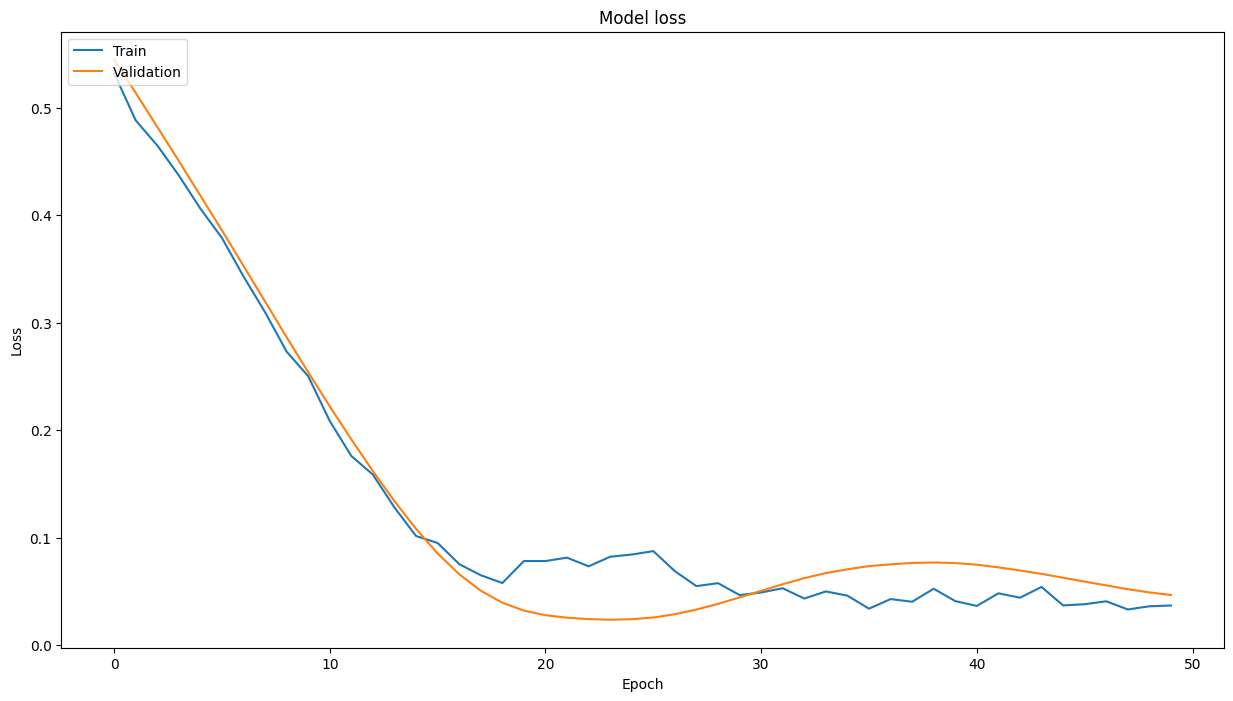

In [312]:
# Train the model
history = model.fit([X['user'], X['book']], y, batch_size=64, epochs=50, validation_split=0.1)

# Plot training & validation loss values
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [313]:
# Predict the ratings
y_pred = model.predict([test_x['user'], test_x['book']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# see predictions
print("Predictions:")
display(y_pred)

1/1 [==============================] - 0s 155ms/step
Predictions:


array([[4.1799583],
       [2.377621 ],
       [2.6400561],
       [2.2298193],
       [2.5730784],
       [2.0564675],
       [2.4339645],
       [3.7973328],
       [4.0248985],
       [4.4207416],
       [3.8650243],
       [4.4636755],
       [3.9587333],
       [2.7118058],
       [2.825222 ],
       [2.96112  ],
       [4.4669514],
       [3.536067 ],
       [3.3074315],
       [3.1067574],
       [3.0605562],
       [2.8594503],
       [3.3549187],
       [2.443426 ]], dtype=float32)

In [325]:
# set predictions and actual ratings to variables - round to 5 decimal places
hidden_ratings_array = (np.array(test_y)*4 + 1).round(3)
predicted_ratings_array = np.array(y_pred).round(3)

In [326]:
# calculate MAE, MSE and RMSE (take the hidden ratings as the true values and the predicted ratings as the predicted values) ==========================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate MAE, MSE and RMSE
print("Using sklearn")
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Manually
print("\n\nManually")
mae = np.mean(np.abs(hidden_ratings_array - predicted_ratings_array)) # Calculate Mean Absolute Error (MAE)
mse = np.mean((hidden_ratings_array - predicted_ratings_array) ** 2) # Calculate Mean Squared Error (MSE)
rmse = np.sqrt(mse) # Calculate Root Mean Squared Error (RMSE)


print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Using sklearn
Mean Absolute Error (MAE): 1.0784583389759064
Mean Squared Error (MSE): 1.9356638031897617
Root Mean Squared Error (RMSE): 1.3912813529943402


Manually
Mean Absolute Error (MAE): 1.1316319447424676
Mean Squared Error (MSE): 1.874663787189226
Root Mean Squared Error (RMSE): 1.3691836206985628


In [327]:
# step 4: calculate Classification Metrics (take the hidden ratings and the predicted ratings and binarise them) ==========================================================================

# Binarise the hidden ratings and predicted ratings
threshold = 3.5
binary_prediction_ratings = (predicted_ratings_array >= threshold).astype(int) 
print(f"If predicted rating is greater than or equal to {threshold}, then 1, else 0\n")
print("Predicted Ratings:", predicted_ratings_array)
print("Binary Predictions:", binary_prediction_ratings)
binary_hidden_ratings = (hidden_ratings_array >= threshold).astype(int)
print("\n")

print("Hidden Ratings:", hidden_ratings_array)
print("Binary Hidden Ratings:", binary_hidden_ratings)

If predicted rating is greater than or equal to 3.5, then 1, else 0

Predicted Ratings: [[4.18 ]
 [2.378]
 [2.64 ]
 [2.23 ]
 [2.573]
 [2.056]
 [2.434]
 [3.797]
 [4.025]
 [4.421]
 [3.865]
 [4.464]
 [3.959]
 [2.712]
 [2.825]
 [2.961]
 [4.467]
 [3.536]
 [3.307]
 [3.107]
 [3.061]
 [2.859]
 [3.355]
 [2.443]]
Binary Predictions: [[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


Hidden Ratings: [4. 3. 4. 5. 5. 5. 5. 3. 2. 5. 4. 4. 5. 3. 2. 3. 4. 2. 3. 2. 3. 4. 5. 3.]
Binary Hidden Ratings: [1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0]


In [328]:
# calculate accuracy using sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# calculate accuracy using sklearn
print("Using sklearn")
accuracy = accuracy_score(binary_hidden_ratings, binary_prediction_ratings)
precision = precision_score(binary_hidden_ratings, binary_prediction_ratings)
recall = recall_score(binary_hidden_ratings, binary_prediction_ratings)
f1 = f1_score(binary_hidden_ratings, binary_prediction_ratings)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# calculate accuracy manually
print("\n\nManually")
true_positives = np.sum((binary_hidden_ratings == 1) & (binary_prediction_ratings == 1))
true_negatives = np.sum((binary_hidden_ratings == 0) & (binary_prediction_ratings == 0))
false_positives = np.sum((binary_hidden_ratings == 0) & (binary_prediction_ratings == 1))
false_negatives = np.sum((binary_hidden_ratings == 1) & (binary_prediction_ratings == 0))

accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Using sklearn
Accuracy: 0.5833333333333334
Precision: 0.6666666666666666
Recall: 0.46153846153846156
F1 Score: 0.5454545454545455


Manually
Accuracy: 0.4895833333333333
Precision: 0.5416666666666666
Recall: 0.375
F1 Score: 0.4431818181818182


### Experiementing

Experimenting with different parameters and visualizing the training process can provide valuable insights into how well our model is performing and where improvements can be made.

- ***Plot Training and Validation Loss:*** This can help you understand if your model is overfitting or underfitting. If your training loss is much lower than your validation loss, your model might be overfitting. If both losses are high, your model might be underfitting.

- ***Experiment with Different Architectures:*** Try adding more layers to your model or increasing the number of neurons in each layer. You could also experiment with different types of layers (e.g., convolutional layers, recurrent layers) and different activation functions.

- ***Tune Hyperparameters***: This includes the learning rate, batch size, number of epochs, and regularization parameters. You could use techniques like grid search or random search to systematically explore different combinations of hyperparameters.

- ***Use Early Stopping:*** This technique allows you to stop training once the model’s performance on a validation set stops improving, which can be useful to prevent overfitting.

- ***Try Different Optimization Algorithms:*** In addition to Adam, there are many other optimization algorithms available in TensorFlow, such as SGD, RMSprop, and Adagrad. Different optimizers might lead to different results.

- ***Regularization:*** If your model is overfitting, you might want to add some form of regularization, such as L1 or L2 regularization, or dropout.

- ***Data Augmentation***: If you have a small dataset, you could artificially increase its size by creating modified versions of your existing data. For example, you could add small amounts of noise to your input data.

- ***Learning Rate Scheduling:*** Instead of using a fixed learning rate, you could decrease it over time or in response to the model’s performance.


In [ ]:
history = model.fit([X_train['user'], X_train['book']], y_train, batch_size=64, epochs=5, validation_split=0.1)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
